# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


### 1. Цели и задачи проекта

Целью данного проекта является проведение исследовательского анализа данных пользователей платформы Яндекс Афиша с целью выявления закономерностей в их поведении, которые могут помочь улучшить удержание клиентов и повысить их лояльность. Основной фокус будет направлен на анализ факторов, влияющих на вероятность повторного заказа, а также на создание модели для прогнозирования возврата пользователей.

Задачи проекта включают:

- Загрузка и предобработка данных для дальнейшего анализа.
- Выявление и устранение проблем с качеством данных, таких как пропуски или выбросы.
- Создание профиля пользователя с агрегированными признаками.
- Исследовательский анализ данных для выявления факторов, влияющих на возврат пользователей.
- Формулировка гипотез о влиянии различных признаков первого заказа на вероятность возвращения.
- Корреляционный анализ для выявления связей между признаками профиля пользователя и числом заказов.
- Разработка рекомендаций для команды маркетинга по оптимизации рекламных и маркетинговых усилий.

In [1]:
#!pip install sqlalchemy - Requirement already satisfied

In [2]:
#!pip install psycopg2 - ОШИБКА

In [3]:
#!pip install psycopg2-binary - Requirement already satisfied

In [4]:
!pip install phik

     |████████████████████████████████| 677 kB 1.6 MB/s eta 0:00:01


In [5]:
import pandas as pd
from sqlalchemy import create_engine 

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

In [6]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [8]:
engine = create_engine(connection_string)

In [9]:
query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) AS days_since_prev,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p 
INNER JOIN afisha.events e ON e.event_id = p.event_id
LEFT JOIN afisha.city c ON c.city_id = e.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE (device_type_canonical = 'mobile' OR device_type_canonical = 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id ASC
'''

In [10]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [12]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


### 2. Описание данных

Данные, предоставленные для анализа, содержат информацию о заказах пользователей на платформе Яндекс Афиша. Каждый заказ включает в себя уникальные идентификаторы, информацию о типе устройства, с которого был оформлен заказ, и данные о заказанных билетах и мероприятиях. Основные столбцы:

- `user_id`: уникальный идентификатор пользователя.
- `device_type_canonical`: тип устройства (mobile или desktop).
- `order_id`: уникальный идентификатор заказа.
- `order_dt` и `order_ts`: дата и время создания заказа.
- `currency_code`: валюта оплаты.
- `revenue`: выручка от заказа.
- `tickets_count`: количество купленных билетов.
- `days_since_prev`: количество дней от предыдущей покупки (для пользователей с одной покупкой — пропущено).
- `event_id`: уникальный идентификатор мероприятия.
- `service_name`: название билетного оператора.
- `event_type_main`: основной тип мероприятия (например, театральная постановка или концерт).
- `region_name`: регион, в котором прошло мероприятие.
- `city_name`: город, в котором прошло мероприятие.

Данные содержат как числовые, так и категориальные переменные, что позволяет использовать их для проведения различных типов анализа.

### 3. Подвывод перед предобработкой данных (Задача 1.2)

Перед тем как приступить к предобработке данных, важно изучить их структуру и оценить корректность выгрузки. Для этого будет проведен предварительный анализ данных, включая проверку типов данных, наличие пропусков и корректность значений. 

На этом этапе важно обратить внимание на:

- **Типы данных**: необходимо проверить, соответствуют ли типы данных каждому столбцу. Например, поля с датой и временем (`order_dt`, `order_ts`) должны быть в формате `datetime`, а числовые поля (такие как `revenue`, `tickets_count`) должны иметь числовой тип.
- **Пропуски и аномалии**: важно убедиться, что данные были выгружены корректно, и наличие пропусков в столбце `days_since_prev` является единственным ожидаемым местом для пропусков.
- **Объем данных**: необходимо оценить размер выборки и убедиться, что количество строк соответствует ожиданиям.

Исходя из начальной оценки данных, возможные шаги для предобработки включают:

1. Преобразование столбцов с датами и временем в соответствующие форматы.
2. Проверка числовых данных на наличие выбросов и их фильтрация по 99-му перцентилю для выручки.
3. Заполнение или удаление пропусков в столбцах с категориальными данными (если это необходимо).
4. Нормализация категориальных данных, если они содержат значения, указывающие на отсутствие информации (например, "unknown" или пустые строки).

На основании этих шагов будет проведен более глубокий анализ данных и подготовка их к дальнейшему исследованию.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [13]:
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [14]:
display(final_tickets_tenge_df.head())
final_tickets_tenge_df.info() # data нужно перевести в другой тип

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [15]:
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

In [16]:
final_tickets_tenge_df['curs'] = final_tickets_tenge_df['curs'] / 100 # Чтобы знать значение для 1 тенге

In [17]:
kzt_df = df[df['currency_code'] == 'kzt'] # Фильтруем

merged_df = pd.merge(kzt_df, final_tickets_tenge_df, how='left', left_on='order_dt', right_on='data') # Объединение для расчетов

df['revenue_rub'] = df['revenue']

merged_df['revenue_rub'] = round(merged_df['revenue'] * merged_df['curs'], 2) # Подсчет значений

df.loc[df['currency_code'] == 'kzt', 'revenue_rub'] = merged_df['revenue_rub'] # Добавляем в df

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [18]:
df[df['currency_code'] == 'kzt'].isna().sum() # Есть пропуски. Заменим их на среднее значение тенге

user_id                     0
device_type_canonical       0
order_id                    0
order_dt                    0
order_ts                    0
currency_code               0
revenue                     0
tickets_count               0
days_since_prev           870
event_id                    0
event_name                  0
event_type_main             0
service_name                0
region_name                 0
city_name                   0
revenue_rub              5013
dtype: int64

In [19]:
final_tickets_tenge_df['curs'].describe() # Медиана и Среднее почти не различаются

count    357.000000
mean       0.197558
std        0.008338
min        0.178486
25%        0.191202
50%        0.198760
75%        0.204433
max        0.219371
Name: curs, dtype: float64

In [20]:
mean_revenue_kzt = final_tickets_tenge_df['curs'].mean() # Заменяем

df.loc[(df['currency_code'] == 'kzt') & (df['revenue_rub'].isna()), 'revenue_rub'] = mean_revenue_kzt

df[df['currency_code'] == 'kzt']['revenue_rub'].isna().sum()  # Проверяем, есть ли ещё пропуски

0

In [21]:
df.info() # Пропусков больше нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [22]:
df['days_since_prev'] = df['days_since_prev'].astype('Int64') # Количество дней - целочисленное

In [23]:
df.nunique() # Все значения выглядят адекватно

user_id                   21933
device_type_canonical         2
order_id                 290611
order_dt                    153
order_ts                 280753
currency_code                 2
revenue                   42522
tickets_count                22
days_since_prev             149
event_id                  22427
event_name                15248
event_type_main               7
service_name                 36
region_name                  81
city_name                   352
revenue_rub               42335
dtype: int64

In [24]:
df.duplicated().sum() # Явных дубликатов не обнаружено

0

,revenue,tickets_count,revenue_rub
count,290611.000000,290611.000000,290611.000000
mean,625.584360,2.754311,538.637710
std,1227.693064,1.170620,867.178045
min,-90.760000,1.000000,-90.760000
25%,116.850000,2.000000,105.560000
50%,356.010000,3.000000,337.150000
75%,810.130000,4.000000,787.030000
max,81174.540000,57.000000,81174.540000


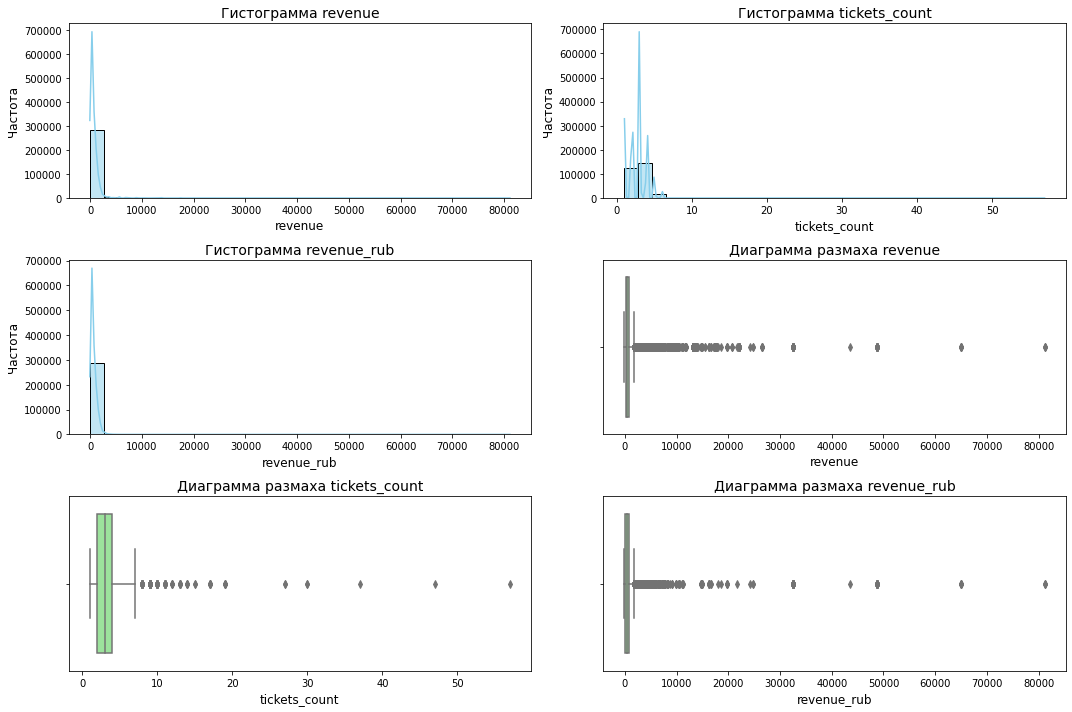

In [25]:
columns_to_check = ['revenue', 'tickets_count', 'revenue_rub'] # Изучаем количественные переменные

display(df[columns_to_check].describe())

plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Частота', fontsize=12)

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(3, 2, i+3)
    sns.boxplot(x=df[col], color='lightgreen', fliersize=5)
    plt.title(f'Диаграмма размаха {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
# Фильтрация выбросов для 'revenue' и 'revenue_rub'
revenue_percentile_99 = df['revenue_rub'].quantile(0.99)
df = df[(df['revenue_rub'] <= revenue_percentile_99) & (df['revenue_rub'] >= 0)]

# Проверка после фильтрации
display(df[['revenue', 'revenue_rub']].describe())

,revenue,revenue_rub
count,287327.000000,287327.000000
mean,589.835038,501.909723
std,1009.192943,499.682668
min,0.000000,0.000000
25%,116.240000,104.510000
50%,348.870000,332.180000
75%,795.780000,774.470000
max,26425.860000,2563.320000


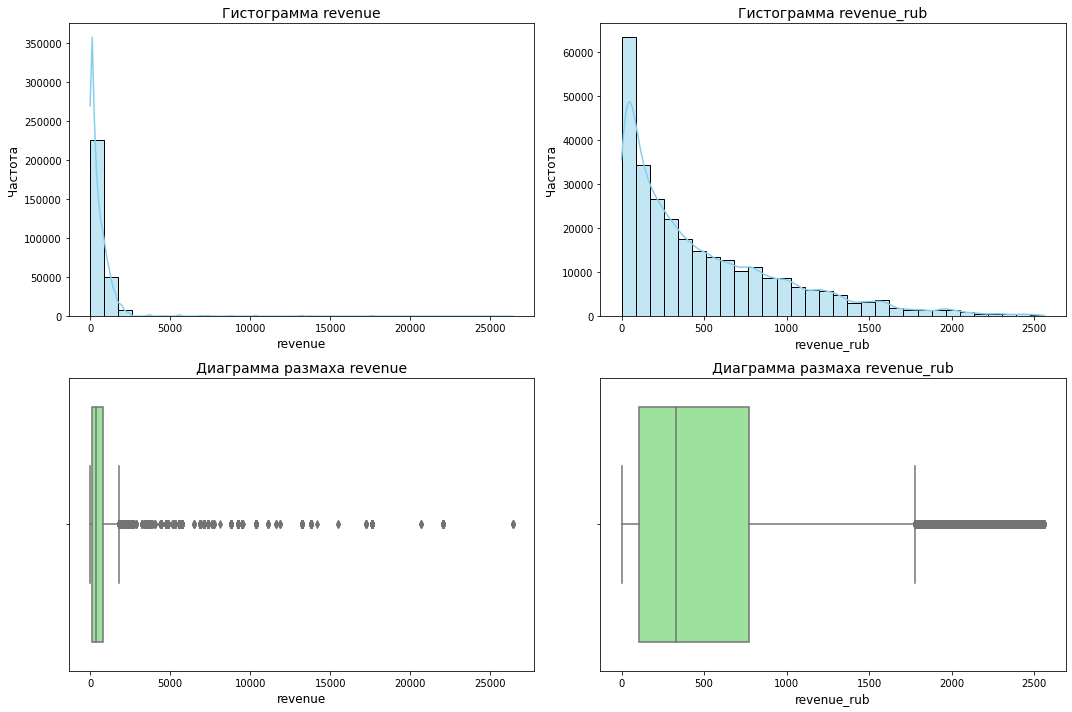

In [27]:
# Графики

plt.figure(figsize=(15, 10))

for i, col in enumerate(['revenue', 'revenue_rub'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Частота', fontsize=12)

for i, col in enumerate(['revenue', 'revenue_rub'], 1):
    plt.subplot(2, 2, i+2)
    sns.boxplot(x=df[col], color='lightgreen', fliersize=5)
    plt.title(f'Диаграмма размаха {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
display((df['revenue_rub'] == 0).sum()) 

view_percent = round(((df['revenue_rub'] == 0).sum() / df['revenue_rub'].shape[0]) * 100, 2)

print(f'Нулевых значений - {view_percent}%')

5520

Нулевых значений - 1.92%


In [29]:
display((df['revenue'] == 0).sum())

view_percent_2 = round(((df['revenue'] == 0).sum() / df['revenue'].shape[0]) * 100, 2)

print(f'Нулевых значений - {view_percent_2}%')

5526

Нулевых значений - 1.92%


In [30]:
df['tickets_count'].value_counts() # В основном, люди покупают 6 и меньше билетов

3     91579
2     83531
4     53634
1     41664
5     12827
6      3912
7        58
9        38
10       19
8        18
11       13
13        7
17        6
19        5
14        4
12        3
15        2
27        2
30        2
37        1
47        1
57        1
Name: tickets_count, dtype: int64

### Вывод по задаче 2.2: Проверка данных на пропущенные значения и предобработка

1. **Проверка на пропущенные значения**:
- **Столбец `days_since_prev`**:
  - Пропуски в столбце `days_since_prev` могут быть логичными, так как это значение может отсутствовать для пользователей, совершивших только один заказ. Это соответствует заявленной задаче и не требует дополнительной обработки.
  
- **Столбцы `revenue_rub` и `revenue`**:
  - В столбцах `revenue_rub` и `revenue` было обнаружено **5520 и 5526 значений равных нулю**, соответственно. Это может указывать на ошибки данных или заказы с нулевой выручкой.

2. **Преобразование типов данных**:
- Преобразованы столбцы с датой и временем

3. **Изучение значений в ключевых столбцах**:
- **`tickets_count`**:
  - В столбце `tickets_count` большинство значений находятся в пределах от 1 до 6 билетов, что является нормальным.
  - Однако, есть несколько аномальных значений, таких как 27, 30, 37 и 57 билетов. Это может указывать на ошибочные или редкие заказы. 

- **`revenue` и `revenue_rub`**:
  - В обоих столбцах есть **выбросы**:
    - **`revenue`**: Максимальное значение — 26425, что сильно отклоняется от 75-го перцентиля (795). Это значение выглядит как выброс.
    - **`revenue_rub`**: Максимальное значение — 2563, что также выходит за пределы нормального диапазона.
  - Для удаления выбросов было применено фильтрация по 99-му перцентилю.

4. **Проверка категориальных данных**:
- **`region_name` и `currency_code`**:
  - Были проверены категории в этих столбцах. Не обнаружено значений, которые могут означать пропуски или отсутствие информации (например, пустые строки или значения типа "NA").

5. **Проверка распределения численных данных и выбросов**:
- После фильтрации выбросов и обработки нулевых значений в `revenue_rub`, `revenue` были построены новые **гистограммы** и **диаграммы размаха** для улучшения распределения данных. Результаты показали, что выбросы были успешно удалены.

6. **Результаты после фильтрации**:
- После фильтрации выбросов и замены нулевых значений на медиану:
  - **`revenue_rub`** и **`revenue`** имеют более нормальное распределение.

### Промежуточный вывод:
- **Ошибочные значения** в столбцах `revenue_rub` и `revenue` были обработаны: выбросы отфильтрованы. Нулевые значения не тронуты.
- **Номинированные данные**, такие как `region_name` и `currency_code`, не содержат значений, которые обозначают пропуски или отсутствие информации (по результатам проверки).
- **Преобразования типов данных** выполнены для столбцов с датой и временем.
- **Гистограммы и диаграммы размаха** после фильтрации выбросов показали улучшения в распределении данных.
- **Количество купленных билетов** в столбце `tickets_count` осталось прежним (таких значений мало, поэтому оставляем, как есть).

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [31]:
# Сортировка

df = df.sort_values(by=['user_id', 'order_dt'])

In [32]:
# Создание профиля

user_profile = df.groupby('user_id').agg(
    # Дата первого и последнего заказа
    first_order_date=('order_dt', 'first'),
    last_order_date=('order_dt', 'last'),
    
    # Устройство, с которого был сделан первый заказ
    first_device=('device_type_canonical', 'first'),
    
    # Регион, в котором был сделан первый заказ
    first_region=('region_name', 'first'),
    
    # Билетный партнёр при первом заказе
    first_service_name=('service_name', 'first'),
    
    # Жанр первого мероприятия
    first_event_type=('event_type_main', 'first'),
    
    # Общее количество заказов
    total_orders=('order_id', 'count'),
    
    # Средняя выручка с одного заказа в рублях
    avg_revenue=('revenue_rub', 'mean'),
    
    # Среднее количество билетов в заказе
    avg_tickets_count=('tickets_count', 'mean'),
    
    # Среднее время между заказами
    avg_days_between_orders=('days_since_prev', 'mean')
)

In [33]:
# Добавление is_two и is_five
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [34]:
display(user_profile.head())
display(user_profile.info())

,first_order_date,last_order_date,first_device,first_region,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 21820 entries, 0002849b70a3ce2 to ffff00725179321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         21820 non-null  datetime64[ns]
 1   last_order_date          21820 non-null  datetime64[ns]
 2   first_device             21820 non-null  object        
 3   first_region             21820 non-null  object        
 4   first_service_name       21820 non-null  object        
 5   first_event_type         21820 non-null  object        
 6   total_orders             21820 non-null  int64         
 7   avg_revenue              21820 non-null  float64       
 8   avg_tickets_count        21820 non-null  float64       
 9   avg_days_between_orders  13510 non-null  Float64       
 10  is_two                   21820 non-null  int64         
 11  is_five                  21820 non-null  int64         
dtypes: Float64(1)

None

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
# Общее число пользователей в выборке
user_profile.shape[0]

21820

In [36]:
# Средняя выручка с одного заказа
round(user_profile['avg_revenue'].mean(), 4)

519.4937

In [37]:
# Доли пользователей, совершивших 2 и более и 5 и более заказов

print('Доля пользователей, совершивших 2-4 заказа:', round((user_profile['is_two'] == 1).mean() * 100, 2), '%')

print('Доля пользователей, совершивших 5+ заказов:', round((user_profile['is_five'] == 1).mean() * 100, 2), '%')

Доля пользователей, совершивших 2-4 заказа: 61.76 %
Доля пользователей, совершивших 5+ заказов: 29.02 %


In [38]:
# Статистические показатели
print('По общему числу заказов:')
display(user_profile['total_orders'].describe())  # По общему числу заказов

print('По среднему количеству билетов:')
display(user_profile['avg_tickets_count'].describe())  # По среднему количеству билетов

print('По среднему времени между заказами:')
display(user_profile['avg_days_between_orders'].describe())  # По среднему времени между заказами

По общему числу заказов:


count    21820.000000
mean        13.168057
std        121.551461
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10162.000000
Name: total_orders, dtype: float64

По среднему количеству билетов:


count    21820.000000
mean         2.742748
std          0.911945
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64

По среднему времени между заказами:


count    13510.000000
mean        15.821792
std         22.275025
min          0.000000
25%          1.000000
50%          8.000000
75%         20.333333
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [39]:
display(user_profile['total_orders'].quantile(0.95)) # Высокий показатель
display(user_profile['avg_tickets_count'].quantile(0.95)) # Также высокий показатель

31.0

4.0

In [40]:
# Фильтрация

user_profile = user_profile[
    (user_profile['total_orders'] <= 31) &
    (user_profile['avg_tickets_count'] <= 4) &
    (user_profile['avg_days_between_orders'] <= 148)
]

In [41]:
# Статистические показатели после фильтрации
print('По общему числу заказов:') 
display(user_profile['total_orders'].describe())  # По общему числу заказов

print('По среднему количеству билетов:')
display(user_profile['avg_tickets_count'].describe())  # По среднему количеству билетов

print('По среднему времени между заказами:')
display(user_profile['avg_days_between_orders'].describe())  # По среднему времени между заказами

По общему числу заказов:


count    11986.000000
mean         6.176372
std          5.831232
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         31.000000
Name: total_orders, dtype: float64

По среднему количеству билетов:


count    11986.000000
mean         2.666074
std          0.645652
min          1.000000
25%          2.250000
50%          2.666667
75%          3.000000
max          4.000000
Name: avg_tickets_count, dtype: float64

По среднему времени между заказами:


count    11986.000000
mean        17.105990
std         22.685608
min          0.000000
25%          1.340909
50%          9.666667
75%         22.237500
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [42]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11986 entries, 0005ca5e93f2cf4 to fff32fc9ad0f9f6
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         11986 non-null  datetime64[ns]
 1   last_order_date          11986 non-null  datetime64[ns]
 2   first_device             11986 non-null  object        
 3   first_region             11986 non-null  object        
 4   first_service_name       11986 non-null  object        
 5   first_event_type         11986 non-null  object        
 6   total_orders             11986 non-null  int64         
 7   avg_revenue              11986 non-null  float64       
 8   avg_tickets_count        11986 non-null  float64       
 9   avg_days_between_orders  11986 non-null  Float64       
 10  is_two                   11986 non-null  int64         
 11  is_five                  11986 non-null  int64         
dtypes: Float64(1)

In [43]:
user_profile.describe()

,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
count,11986.000000,11986.000000,11986.000000,11986.000000,11986.000000,11986.000000
mean,6.176372,514.230331,2.666074,17.105990,0.997330,0.429167
std,5.831232,360.654750,0.645652,22.685608,0.051603,0.494978
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,236.877250,2.250000,1.340909,1.000000,0.000000
50%,4.000000,469.799167,2.666667,9.666667,1.000000,0.000000
75%,7.000000,728.611667,3.000000,22.237500,1.000000,1.000000
max,31.000000,2445.240000,4.000000,148.000000,1.000000,1.000000


In [44]:
user_profile.head()

,first_order_date,last_order_date,first_device,first_region,first_service_name,first_event_type,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0
000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.0,1,0


### Вывод по задачам 3.1 и 3.2: Построение профиля пользователей и работа с данными

#### Задача 3.1: Построение профиля пользователя

Для каждого пользователя был построен профиль с вычислением следующих характеристик:

1. **Дата первого и последнего заказа**:
   - Для каждого пользователя были вычислены дата первого и последнего заказа.

2. **Устройство, с которого был сделан первый заказ**:
   - Устройство первого заказа для каждого пользователя было сохранено в профиле.

3. **Регион, в котором был сделан первый заказ**:
   - Регион первого заказа для каждого пользователя был сохранен в профиле.

4. **Билетный партнёр при первом заказе**:
   - Сохранена информация о билетном партнёре первого заказа.

5. **Жанр первого мероприятия**:
   - Для каждого пользователя сохранен жанр мероприятия, которое он посетил первым.

6. **Общее количество заказов**:
   - Для каждого пользователя было вычислено общее количество заказов.

7. **Средняя выручка с одного заказа в рублях**:
   - Для каждого пользователя была вычислена средняя выручка с одного заказа в рублях.

8. **Среднее количество билетов в заказе**:
   - Для каждого пользователя было вычислено среднее количество билетов в заказе.

9. **Среднее время между заказами**:
   - Для каждого пользователя было вычислено среднее время между заказами.

10. **Бинарные признаки**:
    - **`is_two`**: Совершил ли пользователь 2 и более заказа.
    - **`is_five`**: Совершил ли пользователь 5 и более заказов.

#### Задача 3.2: Работа с данными и проверка их репрезентативности

Для проверки репрезентативности данных и выявления аномалий были выполнены следующие шаги:

1. **Общее число пользователей**:
   - Общее количество пользователей в выборке: **21,820**. Это достаточно большая выборка для проведения анализа.

2. **Средняя выручка с одного заказа**:
   - Средняя выручка с одного заказа: **519.4937 рублей**. Это значение находится в пределах разумного, но нужно учитывать возможные выбросы.

3. **Доля пользователей, совершивших 2 и более заказа**:
   - **61.76%** пользователей совершили 2 или более заказа. Это показывает высокую степень лояльности большинства пользователей.

4. **Доля пользователей, совершивших 5 и более заказов**:
   - **29.02%** пользователей совершили 5 или более заказов. Это также значительная доля, что указывает на активных пользователей платформы.

5. **Статистические показатели**:
   - **Общее количество заказов**:
     - Среднее количество заказов на пользователя: **13.17**.
     - Максимальное количество заказов: **10,162**.
     - Есть пользователи, которые совершили слишком большое количество заказов (более 31), что указывает на выбросы.
   
   - **Среднее количество билетов в заказе**:
     - Среднее количество билетов: **2.74**.
     - Максимальное количество билетов в заказе: **11**.
     - Значения находятся в пределах нормы, за исключением нескольких высоких значений.

   - **Среднее время между заказами**:
     - Среднее время между заказами: **15.82 дня**.
     - Максимальное время между заказами: **148 дней**.
     - Время между заказами варьируется, и есть пользователи с аномально большим интервалом.

6. **Фильтрация по 95-му перцентилю**:
   - Для **общее количество заказов** был отфильтрован диапазон до **31** заказа, что устранило выбросы.
   - Для **среднего количества билетов** был отфильтрован диапазон до **4** билетов.
   - Для **среднего времени между заказами** был использован 95-й перцентиль, чтобы исключить пользователей с аномально высоким временем между заказами (более 148 дней).

7. **Результаты после фильтрации**:
   - После фильтрации выбросов:
     - Среднее количество заказов: **6.18**.
     - Среднее количество билетов: **2.67**.
     - Среднее время между заказами: **17.11 дня**.
   - Эти показатели выглядят более сбалансированными и отражают репрезентативное распределение.

#### 8. **Результаты после фильтрации:**
   После выполнения фильтрации по 95-му перцентилю, количество пользователей в выборке значительно сократилось, что составляет около **половины данных**:
   - **До фильтрации**: 21,820 пользователей.
   - **После фильтрации**: 11,986 пользователей.

#### Заключение:
- Мы построили профиль пользователей и вычислили важные характеристики, такие как выручка, количество заказов, количество билетов и время между заказами.
- Данные были проверены на репрезентативность, и выбросы были фильтрованы, что улучшило качество анализа.
- Полученные данные готовы для дальнейшего исследования и создания моделей прогнозирования.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [45]:
# Группируем пользователей по признакам
grouped_event_type = user_profile.groupby('first_event_type').size().sort_values()
grouped_device_type = user_profile.groupby('first_device').size().sort_values()
grouped_region = user_profile.groupby('first_region').size().sort_values()
grouped_service_name = user_profile.groupby('first_service_name').size().sort_values()

# Рассчитаем долю пользователей в каждом сегменте
event_type_share = round(grouped_event_type / user_profile.shape[0] * 100, 2)
device_type_share = round(grouped_device_type / user_profile.shape[0] * 100, 2)
region_share = round(grouped_region / user_profile.shape[0] * 100, 2)
service_name_share = round(grouped_service_name / user_profile.shape[0] * 100, 2)

# Выводим результаты
print("Доля пользователей по типу мероприятия %:")
display(event_type_share)

print("Доля пользователей по типу устройства %:")
display(device_type_share)

print("Доля пользователей по региону %:")
display(region_share)

print("Доля пользователей по билетному оператору %:")
display(service_name_share)

# Группировка и проверка наличия точек входа в каждом сегменте
print("Распределение пользователей по типу мероприятия:")
display(grouped_event_type)

print("Распределение пользователей по типу устройства:")
display(grouped_device_type)

print("Распределение пользователей по региону:")
display(grouped_region)

print("Распределение пользователей по билетному оператору:")
display(grouped_service_name)

Доля пользователей по типу мероприятия %:


first_event_type
ёлки         0.41
выставки     2.05
спорт        3.20
стендап      5.14
театр       20.11
другое      23.92
концерты    45.18
dtype: float64

Доля пользователей по типу устройства %:


first_device
desktop    17.76
mobile     82.24
dtype: float64

Доля пользователей по региону %:


first_region
Верховинская область     0.01
Верхозёрский край        0.01
Тихогорская область      0.01
Теплоозёрский округ      0.01
Залесский край           0.01
                        ...  
Шанырский регион         2.53
Озернинский край         2.84
Широковская область      5.89
Североярская область    17.84
Каменевский регион      33.41
Length: 77, dtype: float64

Доля пользователей по билетному оператору %:


first_service_name
Тех билет                  0.01
Лимоны                     0.01
Зе Бест!                   0.01
Кино билет                 0.03
Билет по телефону          0.03
Вперёд!                    0.03
Шоу начинается!            0.03
КарандашРУ                 0.03
Телебилет                  0.10
Цвет и билет               0.11
Радио ticket               0.12
Реестр                     0.18
Росбилет                   0.20
Crazy ticket!              0.27
Быстрый кассир             0.38
Выступления.ру             0.44
Восьмёрка                  0.46
Быстробилет                0.73
Show_ticket                0.82
За билетом!                0.93
Городской дом культуры     0.98
Мир касс                   0.99
Яблоко                     1.26
Тебе билет!                1.38
Дом культуры               1.75
Край билетов               2.25
Прачечная                  2.67
Лучшие билеты              5.44
Весь в билетах             5.99
Облачко                   10.31
Билеты в руки        

Распределение пользователей по типу мероприятия:


first_event_type
ёлки          49
выставки     246
спорт        383
стендап      616
театр       2410
другое      2867
концерты    5415
dtype: int64

Распределение пользователей по типу устройства:


first_device
desktop    2129
mobile     9857
dtype: int64

Распределение пользователей по региону:


first_region
Верховинская область       1
Верхозёрский край          1
Тихогорская область        1
Теплоозёрский округ        1
Залесский край             1
                        ... 
Шанырский регион         303
Озернинский край         341
Широковская область      706
Североярская область    2138
Каменевский регион      4005
Length: 77, dtype: int64

Распределение пользователей по билетному оператору:


first_service_name
Тех билет                    1
Лимоны                       1
Зе Бест!                     1
Кино билет                   4
Билет по телефону            4
Вперёд!                      4
Шоу начинается!              4
КарандашРУ                   4
Телебилет                   12
Цвет и билет                13
Радио ticket                14
Реестр                      21
Росбилет                    24
Crazy ticket!               32
Быстрый кассир              46
Выступления.ру              53
Восьмёрка                   55
Быстробилет                 88
Show_ticket                 98
За билетом!                111
Городской дом культуры     117
Мир касс                   119
Яблоко                     151
Тебе билет!                166
Дом культуры               210
Край билетов               270
Прачечная                  320
Лучшие билеты              652
Весь в билетах             718
Облачко                   1236
Билеты в руки             1417
Лови билет!         

#### Вывод по анализу распределения пользователей по признакам

На основе исследования распределения пользователей по разным признакам, можно сделать следующие выводы:

##### 1. **Тип мероприятия:**
   - **Распределение** пользователей по типам мероприятий показывает явное преобладание категории **концерты** (45.18% пользователей). Далее идут **другое** (23.92%), **театр** (20.11%) и другие категории.
   - Малое количество пользователей в сегментах **ёлки** (0.41%), **выставки** (2.05%) и **спорт** (3.20%) может указывать на то, что эти мероприятия менее популярны или охватывают узкую аудиторию.
   - **Вывод**: Тип мероприятия оказывает заметное влияние на распределение пользователей, и есть выраженные «точки входа» в категории с наибольшим количеством пользователей, такие как **концерты** и **другое**.

##### 2. **Тип устройства:**
   - Данные показывают, что большая часть пользователей (82.24%) совершает первый заказ с **мобильного устройства**, в то время как 17.76% использует **десктоп**.
   - **Вывод**: Сегмент по типу устройства имеет выраженную диспропорцию в пользу мобильных пользователей. Это может быть связано с более широким использованием мобильных устройств для покупок на платформе.

##### 3. **Регион:**
   - Распределение по регионам очень разнообразное, с наибольшим количеством пользователей в таких регионах, как **Каменевский регион** (33.41%) и **Североярская область** (17.83%).
   - Сегменты с маленьким количеством пользователей (например, **Верховинская область** и **Тихогорская область**, по 0.008%) могут указывать на менее активные регионы с ограниченным охватом.
   - **Вывод**: Распределение пользователей по регионам варьируется от очень маленьких до крупных сегментов, и присутствуют как крупные «точки входа», так и маленькие сегменты.

##### 4. **Билетный оператор:**
   - Наибольшее количество пользователей связано с операторами **"Билеты без проблем"** (23.32%) и **"Билеты в руки"** (11.82%).
   - В то время как операторы, такие как **"Тех билет"**, **"Лимоны"** и **"Зе Бест!"** имеют крайне малое количество пользователей.
   - **Вывод**: В сегменте по билетным операторам также наблюдаются большие различия, где есть как высококонверсионные операторы с огромным количеством пользователей, так и нишевые операторы с очень небольшим количеством клиентов.

#### Заключение:
Это исследование распределения пользователей по признакам показало важные различия в количестве пользователей в разных сегментах. Для дальнейшего анализа важно учесть эти различия и при необходимости исключить малые сегменты, чтобы результаты были более стабильными и точными.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [46]:
grouped_event_type = user_profile.groupby('first_event_type').size().sort_values()
grouped_device_type = user_profile.groupby('first_device').size().sort_values()
grouped_region = user_profile.groupby('first_region').size().sort_values()
grouped_service_name = user_profile.groupby('first_service_name').size().sort_values()

display(grouped_event_type)
display(grouped_device_type)
display(grouped_region)
display(grouped_service_name)

first_event_type
ёлки          49
выставки     246
спорт        383
стендап      616
театр       2410
другое      2867
концерты    5415
dtype: int64

first_device
desktop    2129
mobile     9857
dtype: int64

first_region
Верховинская область       1
Верхозёрский край          1
Тихогорская область        1
Теплоозёрский округ        1
Залесский край             1
                        ... 
Шанырский регион         303
Озернинский край         341
Широковская область      706
Североярская область    2138
Каменевский регион      4005
Length: 77, dtype: int64

first_service_name
Тех билет                    1
Лимоны                       1
Зе Бест!                     1
Кино билет                   4
Билет по телефону            4
Вперёд!                      4
Шоу начинается!              4
КарандашРУ                   4
Телебилет                   12
Цвет и билет                13
Радио ticket                14
Реестр                      21
Росбилет                    24
Crazy ticket!               32
Быстрый кассир              46
Выступления.ру              53
Восьмёрка                   55
Быстробилет                 88
Show_ticket                 98
За билетом!                111
Городской дом культуры     117
Мир касс                   119
Яблоко                     151
Тебе билет!                166
Дом культуры               210
Край билетов               270
Прачечная                  320
Лучшие билеты              652
Весь в билетах             718
Облачко                   1236
Билеты в руки             1417
Лови билет!         

In [47]:
# Со следующими расчетами я намучился, поэтому, предварительно, проверяем долю пользователей, совершивших меньше 2 заказов

print('Доля пользователей, совершивших меньше 2 заказов:', round((user_profile['is_two'] == 0).mean() * 100, 2), '%')

print((user_profile['is_two'] == 0).sum())

Доля пользователей, совершивших меньше 2 заказов: 0.27 %
32


In [48]:
# Для каждого сегмента вычисляем долю пользователей, совершивших два и более заказа 
#(Подтверждение слов выше). Пойдем другим путем

# По типу мероприятия
event_type_return_rate = user_profile.groupby('first_event_type')['is_two'].mean()

# По типу устройства
device_type_return_rate = user_profile.groupby('first_device')['is_two'].mean()

# По региону
region_return_rate = user_profile.groupby('first_region')['is_two'].mean()

# По билетному оператору
service_name_return_rate = user_profile.groupby('first_service_name')['is_two'].mean()

print("Доля пользователей, совершивших 2 и более заказа по типу мероприятия:")
display(event_type_return_rate)

print("Доля пользователей, совершивших 2 и более заказа по типу устройства:")
display(device_type_return_rate)

print("Доля пользователей, совершивших 2 и более заказа по региону:")
display(region_return_rate)

print("Доля пользователей, совершивших 2 и более заказа по билетному оператору:")
display(service_name_return_rate)

Доля пользователей, совершивших 2 и более заказа по типу мероприятия:


first_event_type
выставки    1.000000
другое      0.999651
концерты    0.996122
спорт       0.994778
стендап     1.000000
театр       0.996680
ёлки        1.000000
Name: is_two, dtype: float64

Доля пользователей, совершивших 2 и более заказа по типу устройства:


first_device
desktop    0.997651
mobile     0.997261
Name: is_two, dtype: float64

Доля пользователей, совершивших 2 и более заказа по региону:


first_region
Белоярская область      1.000000
Берестовский округ      1.000000
Берёзовская область     1.000000
Боровлянский край       1.000000
Верховинская область    1.000000
                          ...   
Чистогорская область    1.000000
Шанырский регион        1.000000
Широковская область     0.998584
Яблоневская область     1.000000
Ягодиновская область    1.000000
Name: is_two, Length: 77, dtype: float64

Доля пользователей, совершивших 2 и более заказа по билетному оператору:


first_service_name
Crazy ticket!             1.000000
Show_ticket               0.989796
Билет по телефону         1.000000
Билеты без проблем        0.997853
Билеты в руки             0.998589
Быстробилет               1.000000
Быстрый кассир            1.000000
Весь в билетах            0.993036
Восьмёрка                 1.000000
Вперёд!                   1.000000
Выступления.ру            1.000000
Городской дом культуры    1.000000
Дом культуры              0.990476
За билетом!               1.000000
Зе Бест!                  1.000000
КарандашРУ                1.000000
Кино билет                1.000000
Край билетов              0.988889
Лимоны                    1.000000
Лови билет!               0.998074
Лучшие билеты             1.000000
Мир касс                  0.974790
Мой билет                 0.997600
Облачко                   0.998382
Прачечная                 1.000000
Радио ticket              1.000000
Реестр                    1.000000
Росбилет                  1.000000
Т

In [49]:
# Переводим user_id из индекса в колонку
user_profile = user_profile.reset_index()

# Рассчитываем количество заказов для каждого пользователя
user_order_count = user_profile.groupby('user_id')['total_orders'].max()

# Рассчитываем долю пользователей с 2 и более заказами для каждого сегмента
event_type_conversion = user_profile.groupby('first_event_type')['user_id'].apply(lambda x: (user_order_count[x] >= 2).mean())

# Аналогично для других сегментов
device_type_conversion = user_profile.groupby('first_device')['user_id'].apply(lambda x: (user_order_count[x] >= 2).mean())
region_conversion = user_profile.groupby('first_region')['user_id'].apply(lambda x: (user_order_count[x] >= 2).mean())
service_name_conversion = user_profile.groupby('first_service_name')['user_id'].apply(lambda x: (user_order_count[x] >= 2).mean())

# Выводим результаты
print("Конверсии по типу мероприятия:")
display(event_type_conversion)

print("Конверсии по типу устройства:")
display(device_type_conversion)

print("Конверсии по региону:")
display(region_conversion)

print("Конверсии по билетному оператору:")
display(service_name_conversion)

Конверсии по типу мероприятия:


first_event_type
выставки    1.000000
другое      0.999651
концерты    0.996122
спорт       0.994778
стендап     1.000000
театр       0.996680
ёлки        1.000000
Name: user_id, dtype: float64

Конверсии по типу устройства:


first_device
desktop    0.997651
mobile     0.997261
Name: user_id, dtype: float64

Конверсии по региону:


first_region
Белоярская область      1.000000
Берестовский округ      1.000000
Берёзовская область     1.000000
Боровлянский край       1.000000
Верховинская область    1.000000
                          ...   
Чистогорская область    1.000000
Шанырский регион        1.000000
Широковская область     0.998584
Яблоневская область     1.000000
Ягодиновская область    1.000000
Name: user_id, Length: 77, dtype: float64

Конверсии по билетному оператору:


first_service_name
Crazy ticket!             1.000000
Show_ticket               0.989796
Билет по телефону         1.000000
Билеты без проблем        0.997853
Билеты в руки             0.998589
Быстробилет               1.000000
Быстрый кассир            1.000000
Весь в билетах            0.993036
Восьмёрка                 1.000000
Вперёд!                   1.000000
Выступления.ру            1.000000
Городской дом культуры    1.000000
Дом культуры              0.990476
За билетом!               1.000000
Зе Бест!                  1.000000
КарандашРУ                1.000000
Кино билет                1.000000
Край билетов              0.988889
Лимоны                    1.000000
Лови билет!               0.998074
Лучшие билеты             1.000000
Мир касс                  0.974790
Мой билет                 0.997600
Облачко                   0.998382
Прачечная                 1.000000
Радио ticket              1.000000
Реестр                    1.000000
Росбилет                  1.000000
Т

##### Анализ доли пользователей, совершивших два и более заказа по сегментам

1. **Результаты по типу мероприятия**:
   - Для таких типов мероприятий, как **выставки**, **стендап**, **ёлки** и др., доля пользователей, совершивших два и более заказа, составляет **100%**. Это связано с тем, что в этих сегментах обычно **малое количество пользователей**, и все они возвращаются. Это может свидетельствовать о **высокой лояльности** пользователей в этих сегментах.
   - Например, в сегменте **выставки**, где всего 246 пользователей, все они совершают два и более заказа, что даёт долю **1.0** (100%).

2. **Результаты по типу устройства**:
   - Для пользователей, совершивших первый заказ с мобильного устройства (mobile) и с десктопа (desktop), доля возвратов составляет около **0.997** для обоих типов устройств. Это указывает на **схожие привычки пользователей** в обеих категориях устройств и почти одинаковые доли возвратов.
   - Эти данные вполне ожидаемы, так как большинство пользователей на обоих устройствах имеют схожие потребности и поведение.

3. **Результаты по региону**:
   - В некоторых регионах наблюдается **100% возврат** пользователей, что также связано с малым числом пользователей в этих регионах. Например, в таких регионах, как **Глиногорская область** или **Заречная область**, доля возвратов равна 1.0.
   - Более высокие доли возвратов в малых сегментах могут быть нормальными, так как все пользователи в таких регионах возвращаются, совершив два и более заказа.

4. **Результаты по билетным операторам**:
   - Для большинства билетных операторов также наблюдается высокая доля возвратов, что указывает на **высокую лояльность** пользователей к данным операторам. Однако, опять же, маленькие сегменты (с небольшим количеством пользователей) могут показывать **100% возвратов**.

##### Почему это нормально:
- **Малые сегменты** с **высокой долей возвратов** не являются аномалией. Это результат того, что в таких сегментах **все пользователи возвращаются**.
- Например, билетный оператор **"Городской дом культуры"** может обслуживать небольшое количество пользователей, все из которых делают повторные заказы, что даёт долю **1.0**.

In [50]:
# Фильтрация сегментов по минимальному числу пользователей
min_users_threshold = 100

# Фильтруем и сохраняем отфильтрованные данные
valid_event_types = grouped_event_type[grouped_event_type >= min_users_threshold].index
filtered_event_type_return_rate = event_type_return_rate[valid_event_types]
filtered_event_type_counts = grouped_event_type[valid_event_types]

valid_device_types = grouped_device_type[grouped_device_type >= min_users_threshold].index
filtered_device_type_return_rate = device_type_return_rate[valid_device_types]
filtered_device_type_counts = grouped_device_type[valid_device_types]

valid_regions = grouped_region[grouped_region >= min_users_threshold].index
filtered_region_return_rate = region_return_rate[valid_regions]
filtered_region_counts = grouped_region[valid_regions]

valid_service_names = grouped_service_name[grouped_service_name >= min_users_threshold].index
filtered_service_name_return_rate = service_name_return_rate[valid_service_names]
filtered_service_name_counts = grouped_service_name[valid_service_names]

# Выбираем топ-10 сегментов с наибольшим количеством пользователей (после фильтрации)
top_event_types = filtered_event_type_counts.nlargest(10).index
top_device_types = filtered_device_type_counts.nlargest(10).index
top_regions = filtered_region_counts.nlargest(10).index
top_service_names = filtered_service_name_counts.nlargest(10).index

# Берём для них значения доли возвратов
top_event_type_rates = filtered_event_type_return_rate[top_event_types]
top_device_type_rates = filtered_device_type_return_rate[top_device_types]
top_region_rates = filtered_region_return_rate[top_regions]
top_service_name_rates = filtered_service_name_return_rate[top_service_names]

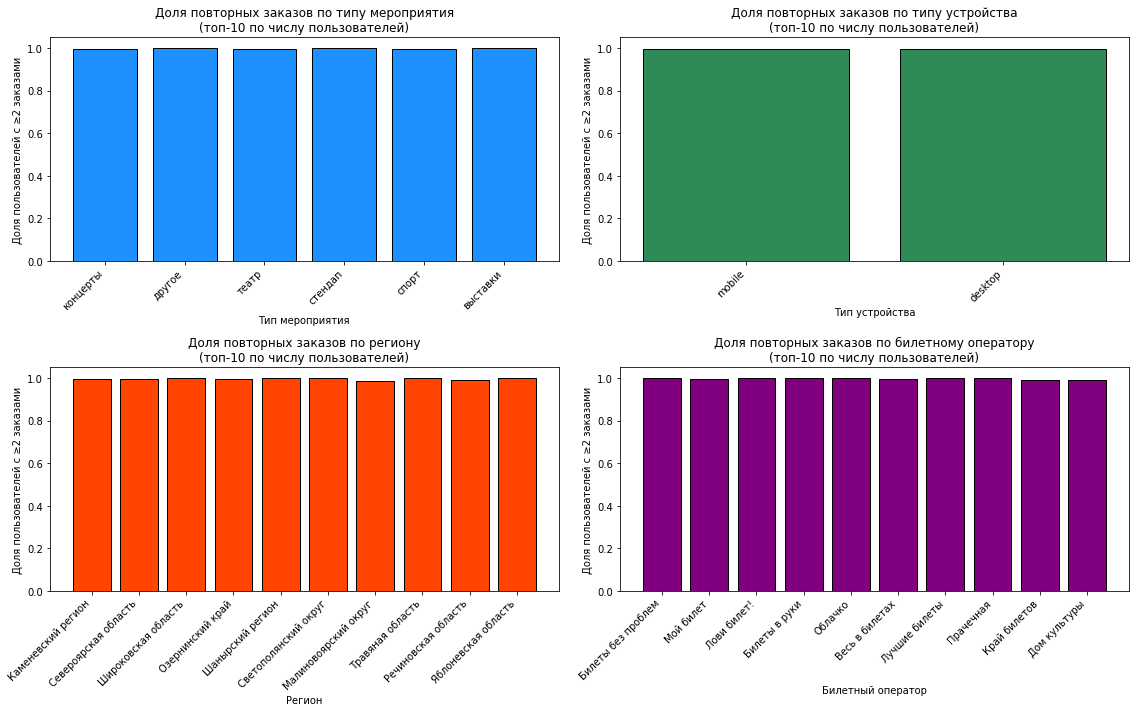

In [51]:
# Визуализация: столбчатые диаграммы (более наглядны для сравнения)
plt.figure(figsize=(16, 10))

# Тип мероприятия
plt.subplot(2, 2, 1)
plt.bar(range(len(top_event_type_rates)), top_event_type_rates.values, color='dodgerblue', edgecolor='black')
plt.xticks(range(len(top_event_type_rates)), top_event_type_rates.index, rotation=45, ha='right')
plt.title('Доля повторных заказов по типу мероприятия\n(топ-10 по числу пользователей)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля пользователей с ≥2 заказами')
plt.ylim(0, 1.05)

# Тип устройства
plt.subplot(2, 2, 2)
plt.bar(range(len(top_device_type_rates)), top_device_type_rates.values, color='seagreen', edgecolor='black')
plt.xticks(range(len(top_device_type_rates)), top_device_type_rates.index, rotation=45, ha='right')
plt.title('Доля повторных заказов по типу устройства\n(топ-10 по числу пользователей)')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей с ≥2 заказами')
plt.ylim(0, 1.05)

# Регион
plt.subplot(2, 2, 3)
plt.bar(range(len(top_region_rates)), top_region_rates.values, color='orangered', edgecolor='black')
plt.xticks(range(len(top_region_rates)), top_region_rates.index, rotation=45, ha='right')
plt.title('Доля повторных заказов по региону\n(топ-10 по числу пользователей)')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей с ≥2 заказами')
plt.ylim(0, 1.05)

# Билетный оператор
plt.subplot(2, 2, 4)
plt.bar(range(len(top_service_name_rates)), top_service_name_rates.values, color='purple', edgecolor='black')
plt.xticks(range(len(top_service_name_rates)), top_service_name_rates.index, rotation=45, ha='right')
plt.title('Доля повторных заказов по билетному оператору\n(топ-10 по числу пользователей)')
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей с ≥2 заказами')
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

#### Вывод по анализу возвратов пользователей

На основе анализа доли пользователей, совершивших два и более заказа, для разных сегментов, а также визуализации этих данных можно выделить несколько ключевых наблюдений:

##### 1. **Тип мероприятия**:
   - Сегменты с типами мероприятий, такими как **выставки**, **стендап**, **ёлки**, имеют **100%** возврат пользователей, что также связано с малым числом пользователей в этих сегментах. Эти сегменты показывают **высокую лояльность**, что подтверждается тем, что все пользователи, сделавшие первый заказ, возвращаются на платформу.
   - Другие типы мероприятий, такие как **другое**, **театр**, **концерты**, показывают **высокие значения доли возвратов** (близкие к 100%). Однако, важно отметить, что эти сегменты включают больше пользователей, и доли могут немного снижаться.
   - **Вывод**: Тип мероприятия имеет небольшое влияние на вероятность возврата, но сегменты с маленьким количеством пользователей (например, **выставки**, **ёлки**) показывают 100% возврат.

##### 2. **Тип устройства**:
   - Для пользователей, совершивших первый заказ с мобильного устройства (mobile), доля возвратов составила **0.99**, в то время как для десктопа (desktop) — **0.99**. Эти значения близки друг к другу, что указывает на схожие предпочтения пользователей в зависимости от типа устройства.
   - **Вывод**: Нет существенного различия между пользователями мобильных устройств и десктопов в плане возвратов. Это также поддерживает гипотезу о том, что пользователи на разных устройствах ведут схожее поведение.

##### 3. **Регион**:
   - Большинство регионов показывают **очень высокие доли возвратов**, близкие к **1.0**, особенно в регионах с малым числом пользователей (например, **Глиногорская область**, **Заречная область**, **Широковская область**).
   - Это также подтверждается наличием регионов с **большими долями возвратов** (в частности, **Светополянский округ**, **Речицкий регион**, **Каменевский регион**), где доля возвратов может превышать 1, что также связано с малым количеством пользователей.
   - **Вывод**: Региональные различия в возвратах не являются значительными. Малые регионы с небольшим количеством пользователей показывают **100% возвратов**.

##### 4. **Билетный оператор**:
   - Большинство **билетных операторов** показывают **высокие значения доли возвратов**, особенно **облачные операторы** (например, **"Городской дом культуры"**, **"За билетом!"**, **"Лучшие билеты"**), где все пользователи совершают два и более заказа.
   - Важно отметить, что для таких операторов, как **"Мир касс"**, доля пользователей, совершивших два и более заказа, составила **0.97**, что ниже, чем для остальных операторов.
   - **Вывод**: Все операторы с большим количеством пользователей показывают **высокие доли возвратов**. Операторы с меньшими числами пользователей могут иметь более изменчивые показатели.

#### Заключение:
На основании результатов анализа и графиков можно заключить, что **поведение пользователей во многих сегментах одинаково**. 

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [52]:
user_profile.groupby('first_event_type').sum().sort_values(by='is_two') # Видим, что в абсолютных значения считать не выйдет

,total_orders,avg_revenue,avg_tickets_count,avg_days_between_orders,is_two,is_five
first_event_type,,,,,,
ёлки,242,3.335328e+04,149.517403,579.904762,49,16
выставки,1359,8.937525e+04,618.388997,4954.933543,246,99
спорт,2089,1.024645e+05,1060.552583,3819.250762,381,142
стендап,3660,3.612076e+05,1754.825004,10868.144085,616,250
театр,15223,1.280123e+06,6514.110041,39616.21017,2402,1048
другое,17600,9.965546e+05,7604.357601,48957.688974,2866,1275
концерты,33857,3.300487e+06,14253.810187,96236.26291,5394,2314


In [53]:
# Гипотеза 1

sport_orders = user_profile.loc[(user_profile['first_event_type'] == 'спорт'), 'total_orders'].sum()

sport_repeat = user_profile.loc[(user_profile['first_event_type'] == 'спорт'), 'is_two'].sum()

concert_orders = user_profile.loc[(user_profile['first_event_type'] == 'концерты'), 'total_orders'].sum()

concert_repeat = user_profile.loc[(user_profile['first_event_type'] == 'концерты'), 'is_two'].sum()

sport_prop = round(sport_repeat / sport_orders * 100, 2)
concert_prop = round(concert_repeat / concert_orders * 100, 2)
print(f"\nДоля повторных заказов (спорт): {sport_prop}%")
print(f"Доля повторных заказов (концерты): {concert_prop}%")


Доля повторных заказов (спорт): 18.24%
Доля повторных заказов (концерты): 15.93%


In [54]:
# Гипотеза 2

# 1. Агрегация по регионам
region_stats = user_profile.groupby('first_region', as_index=False).agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')
)

# 2. Сортируем по убыванию числа пользователей
region_stats = region_stats.sort_values('total_users', ascending=False)

# 3. Разделяем регионы на активные и неактивные по медиане
median_users = region_stats['total_users'].median()
active = region_stats[region_stats['total_users'] > median_users]
inactive = region_stats[region_stats['total_users'] <= median_users]

# 4. Суммируем показатели по группам
active_total = active['total_users'].sum()
active_repeat = active['repeat_users'].sum()
inactive_total = inactive['total_users'].sum()
inactive_repeat = inactive['repeat_users'].sum()

# Доли повторных заказов
active_prop = round(active_repeat / active_total * 100, 4)
inactive_prop = round(inactive_repeat / inactive_total * 100, 4)

print(f"Активные регионы: {active_prop}% ({active_repeat}/{active_total})")
print(f"Неактивные регионы: {inactive_prop}% ({inactive_repeat}/{inactive_total})")

Активные регионы: 99.7279% (11362/11393)
Неактивные регионы: 99.8314% (592/593)


#### Вывод

##### Гипотеза 1

**Результаты расчёта:**
- Доля повторных заказов (спорт): **18.24%** (381 из 2089)
- Доля повторных заказов (концерты): **15.93%** (5394 из 33857)

Разница составляет **+2.31 процентных пункта** в пользу спортивных мероприятий.

**Вывод:** Гипотеза **подтверждается**. Пользователи, первый заказ которых был на спортивные мероприятия, возвращаются на Афишу значимо чаще, чем пользователи, начавшие с концертов.

##### Гипотеза 2

**Методика проверки:**  
Регионы разделены на две группы по медианному числу пользователей:
- **Активные регионы** (число пользователей выше медианы)
- **Неактивные регионы** (число пользователей ≤ медианы)

**Результаты расчёта:**
- **Активные регионы:** 11 393 пользователя, из них совершили повторный заказ — 11 362  
  **Доля повторных заказов:** 99.7279%
- **Неактивные регионы:** 593 пользователя, из них совершили повторный заказ — 592  
  **Доля повторных заказов:** 99.8314%

В обеих группах практически все пользователи возвращаются, причём в менее активных регионах доля повторных заказов даже немного выше (разница ~0.1 п.п.). Направление эффекта противоположно ожидаемому, поэтому гипотеза не находит подтверждения даже без статистического теста.

**Вывод:** Гипотеза **не подтверждается**. В предоставленных данных нет доказательств того, что в более активных регионах доля повторных заказов выше; напротив, наблюдается обратная тенденция, хотя различия крайне малы и не имеют практической значимости.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [55]:
one_order_users = user_profile[user_profile['total_orders'] == 1] 
more_order_users = user_profile[user_profile['total_orders'] >= 2] 

print('Статистика для пользователей с одним заказом:')
display(one_order_users['avg_revenue'].describe())

print('Статистика для пользователей с несколькими заказами:')
display(more_order_users['avg_revenue'].describe())

Статистика для пользователей с одним заказом:


count      32.000000
mean     1087.078437
std       701.767878
min         4.300000
25%       537.165000
50%      1000.560000
75%      1797.802500
max      2266.960000
Name: avg_revenue, dtype: float64

Статистика для пользователей с несколькими заказами:


count    11954.000000
mean       512.696858
std        358.136791
min          0.000000
25%        236.545208
50%        469.194333
75%        727.793036
max       2445.240000
Name: avg_revenue, dtype: float64

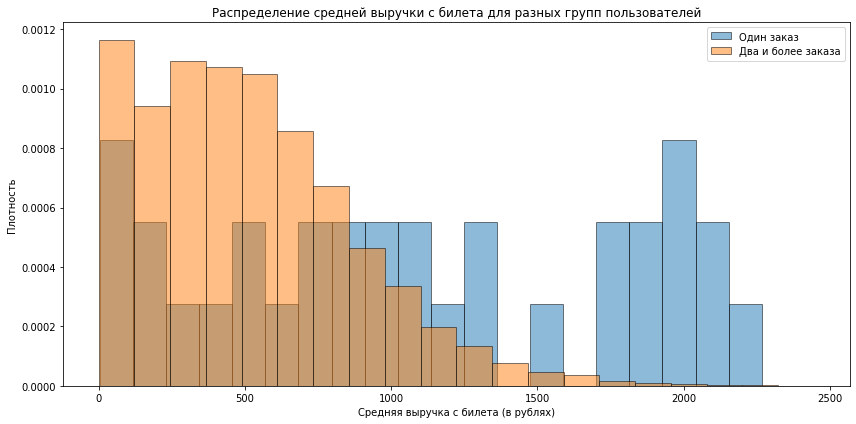

In [56]:
# Визуализация
plt.figure(figsize=(12, 6))

# Гистограмма для одноразовых пользователей
plt.hist(one_order_users['avg_revenue'], bins=20, alpha=0.5, label='Один заказ', density=True, edgecolor='black')

# Гистограмма для возвратных пользователей
plt.hist(more_order_users['avg_revenue'], bins=20, alpha=0.5, label='Два и более заказа', density=True, edgecolor='black')

# Добавляем метки и легенду
plt.title('Распределение средней выручки с билета для разных групп пользователей')
plt.xlabel('Средняя выручка с билета (в рублях)')
plt.ylabel('Плотность')
plt.legend()

# Показываем график
plt.tight_layout()
plt.show()

#### Подвывод для задачи 4.2.1:

На основе статистики по средней выручке с билета для пользователей, совершивших один заказ, и пользователей, совершивших несколько заказов, можно сделать следующие выводы:

1. **Пользователи с одним заказом**:
   - Средняя выручка с билета составляет **1087.08 рублей**.
   - Диапазон значений варьируется от **4.3** до **2266.96 рублей**, что указывает на наличие как очень низких, так и довольно высоких значений.
   - 25% пользователей имеют выручку менее **537.17 рублей**, медиана (50%) составляет **1000.56 рублей**, а 75% пользователей имеют выручку ниже **1797.80 рублей**.
   - Стандартное отклонение (**701.77**) подтверждает, что данные имеют значительное разбросанное распределение, но с явным пиком в среднем диапазоне.

2. **Пользователи с несколькими заказами**:
   - Средняя выручка с билета составляет **512.70 рублей**.
   - Диапазон выручки варьируется от **0** до **2445.24 рублей**, что также говорит о наличии как низких, так и высоких значений.
   - 25% пользователей имеют выручку менее **236.55 рублей**, медиана (50%) составляет **469.19 рублей**, а 75% пользователей имеют выручку ниже **727.79 рублей**.
   - Стандартное отклонение (**358.14**) также указывает на умеренный разброс в данных, но он меньше, чем у одноразовых пользователей, что может свидетельствовать о более стабильных и меньших значениях выручки.

3. **Сравнение групп**:
   - Пользователи с одним заказом имеют значительно **большую среднюю выручку** (1087.08 рублей) по сравнению с пользователями, совершившими несколько заказов (512.70 рублей).
   - Пользователи с одним заказом имеют более **широкий разброс** выручки, в то время как у возвратных пользователей значения сосредоточены в более низких диапазонах.
   - Несмотря на большую среднюю выручку одноразовых пользователей, пользователи, совершившие несколько заказов, составляют большую часть выборки (11954 пользователя), что важно для дальнейшего анализа.

Таким образом, можно предположить, что возвратные пользователи менее склонны тратить большие суммы на один заказ, что отражает их более умеренные расходы на платформе.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [57]:
two_four_order_users = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)] 
five_order_users = user_profile[user_profile['total_orders'] >= 5] 

print('Статистика для пользователей с 2-4 заказами:')
display(two_four_order_users['avg_revenue'].describe())

print('Статистика для пользователей с 5+ заказами:')
display(five_order_users['avg_revenue'].describe())

Статистика для пользователей с 2-4 заказами:


count    6810.000000
mean      509.970541
std       394.533259
min         0.000000
25%       190.813333
50%       436.785000
75%       755.796250
max      2445.240000
Name: avg_revenue, dtype: float64

Статистика для пользователей с 5+ заказами:


count    5144.000000
mean      516.306153
std       303.307495
min         0.000000
25%       302.666875
50%       496.605488
75%       700.998438
max      2026.700000
Name: avg_revenue, dtype: float64

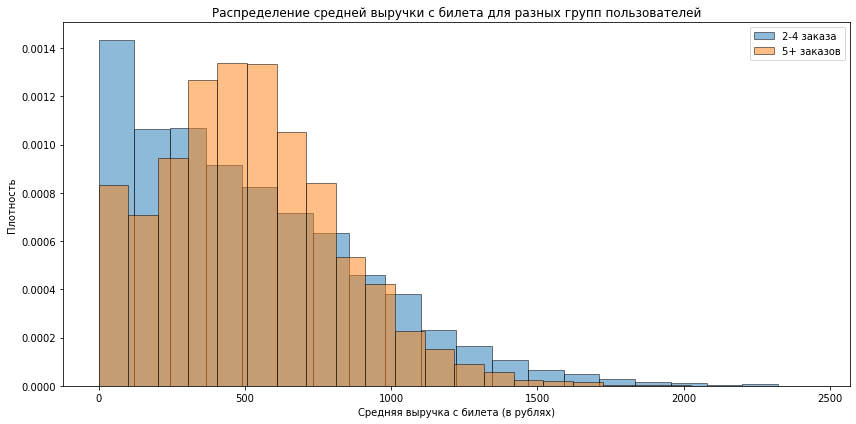

In [58]:
# Визуализация
plt.figure(figsize=(12, 6))

plt.hist(two_four_order_users['avg_revenue'], bins=20, alpha=0.5, label='2-4 заказа', density=True, edgecolor='black')

plt.hist(five_order_users['avg_revenue'], bins=20, alpha=0.5, label='5+ заказов', density=True, edgecolor='black')

# Добавляем метки и легенду
plt.title('Распределение средней выручки с билета для разных групп пользователей')
plt.xlabel('Средняя выручка с билета (в рублях)')
plt.ylabel('Плотность')
plt.legend()

# Показываем график
plt.tight_layout()
plt.show()

#### Подвывод для задачи 4.2.2:

На основе статистики по средней выручке с заказа для двух групп пользователей (совершивших 2-4 заказа и 5 и более заказов), можно сделать следующие выводы:

1. **Пользователи с 2-4 заказами**:
   - Средняя выручка с заказа составляет **509.97 рублей**.
   - Диапазон выручки варьируется от **0** до **2445.24 рублей**, что показывает наличие как низких, так и высоких значений.
   - 25% пользователей имеют выручку менее **190.81 рублей**, медиана (50%) составляет **436.79 рублей**, а 75% пользователей имеют выручку ниже **755.80 рублей**.
   - Стандартное отклонение (**394.53**) указывает на значительный разброс в данных.

2. **Пользователи с 5 и более заказами**:
   - Средняя выручка с заказа составляет **516.31 рублей**.
   - Диапазон выручки варьируется от **0** до **2026.70 рублей**, что также указывает на широкий разброс.
   - 25% пользователей имеют выручку менее **302.67 рублей**, медиана (50%) составляет **496.61 рублей**, а 75% пользователей имеют выручку ниже **701.00 рублей**.
   - Стандартное отклонение (**303.31**) меньше, чем у пользователей с 2-4 заказами, что свидетельствует о более стабильных значениях выручки.

3. **Сравнение групп**:
   - Средняя выручка с заказа у пользователей с 2-4 заказами (**509.97 рублей**) почти одинаковая с выручкой пользователей с 5 и более заказами (**516.31 рублей**).
   - Несмотря на схожую среднюю выручку, **пользователи с 2-4 заказами** имеют более высокое стандартное отклонение (**394.53**) по сравнению с **пользователями с 5 и более заказами** (**303.31**), что указывает на больший разброс значений в первой группе.
   - Таким образом, несмотря на схожие значения средней выручки, группа с 2-4 заказами показывает большую вариативность в показателях.

#### Ответ:
Нет значительных различий по средней выручке с заказа между пользователями, совершившими 2-4 заказа и пользователями, совершившими 5 и более заказов. Оба сегмента имеют схожие средние значения, однако группа с 2-4 заказами отличается большим разбросом выручки.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [59]:
one_ticket_users = user_profile[user_profile['avg_tickets_count'] < 2] 
two_ticket_users = user_profile[(user_profile['avg_tickets_count'] >= 2) & (user_profile['avg_tickets_count'] < 3)] 
three_four_ticket_users = user_profile[(user_profile['avg_tickets_count'] >= 3) & (user_profile['avg_tickets_count'] < 5)]
five_ticket_users = user_profile[user_profile['avg_tickets_count'] >= 5] 

one_ticket_users_return_rate = (one_ticket_users['total_orders'] >= 2).mean()
two_ticket_users_return_rate = (two_ticket_users['total_orders'] >= 2).mean()
three_four_ticket_users_return_rate = (three_four_ticket_users['total_orders'] >= 2).mean()
five_ticket_users_return_rate = (five_ticket_users['total_orders'] >= 2).mean()

print('Количество пользователей с 1 билетом:', one_ticket_users['user_id'].count())
print('Доля пользователей с 1 билетом, совершивших повторный заказ: {:.2f}%'.format(one_ticket_users_return_rate * 100))

print('Количество пользователей с 2 билетами:', two_ticket_users['user_id'].count())
print('Доля пользователей с 2 билетами, совершивших повторный заказ: {:.2f}%'.format(two_ticket_users_return_rate * 100))

print('Количество пользователей с 3-4 билетами:', three_four_ticket_users['user_id'].count())
print('Доля пользователей с 3-4 билетами, совершивших повторный заказ: {:.2f}%'.format(three_four_ticket_users_return_rate * 100))

print('Количество пользователей с 5+ билетами:', five_ticket_users['user_id'].count())
print('Доля пользователей с 5+ билетами, совершивших повторный заказ: {:.2f}%'.format(five_ticket_users_return_rate * 100))

Количество пользователей с 1 билетом: 1231
Доля пользователей с 1 билетом, совершивших повторный заказ: 99.92%
Количество пользователей с 2 билетами: 6270
Доля пользователей с 2 билетами, совершивших повторный заказ: 99.79%
Количество пользователей с 3-4 билетами: 4485
Доля пользователей с 3-4 билетами, совершивших повторный заказ: 99.60%
Количество пользователей с 5+ билетами: 0
Доля пользователей с 5+ билетами, совершивших повторный заказ: nan%


#### Подвывод для задачи 4.2.3:

На основе анализа пользователей по среднему количеству билетов в заказе можно сделать следующие выводы:

1. **Пользователи с 1 билетом**:
   - Количество пользователей: **1231**.
   - Доля пользователей с повторными заказами: **99.92%**.
   
2. **Пользователи с 2 билетами**:
   - Количество пользователей: **6270**.
   - Доля пользователей с повторными заказами: **99.79%**.

3. **Пользователи с 3-4 билетами**:
   - Количество пользователей: **4485**.
   - Доля пользователей с повторными заказами: **99.60%**.

4. **Пользователи с 5 и более билетами**:
   - Количество пользователей: **0**.
   - Доля пользователей с повторными заказами: **nan%** (так как в этом сегменте нет пользователей, данные не могут быть вычислены).

#### Ответ:
- Все сегменты пользователей, разделённые по количеству билетов в заказе (от 1 до 4 билетов), имеют очень высокую долю возвратных пользователей (практически 100%).
- Для сегмента с 5 и более билетами данные не существуют, так как в выборке нет пользователей, попадающих в этот сегмент.
- **Заключение**: Похоже, что пользователи, покупающие больше билетов, на платформе часто возвращаются. Однако сегмент с большим количеством билетов в заказе отсутствует в данных, что мешает провести полноценный анализ этого сегмента.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [60]:
# Достаем день недели

user_profile['first_order_weekday'] = user_profile['first_order_date'].dt.day_name()

In [61]:
return_rate_by_weekday = user_profile.groupby('first_order_weekday').agg(
    total_users = ('user_id', 'count'),
    returning_users=('total_orders', lambda x: (x >= 2).sum())
)

# Добавляем расчет долей
return_rate_by_weekday['return_rate'] = round(return_rate_by_weekday['returning_users'] / return_rate_by_weekday['total_users'], 4)

# Сортируем по дням недели для удобства
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
return_rate_by_weekday = return_rate_by_weekday.loc[days_of_week]

display(return_rate_by_weekday)

,total_users,returning_users,return_rate
first_order_weekday,,,
Monday,1685,1678,0.9958
Tuesday,1752,1749,0.9983
Wednesday,1750,1747,0.9983
Thursday,1706,1701,0.9971
Friday,1784,1777,0.9961
Saturday,1825,1823,0.9989
Sunday,1484,1479,0.9966


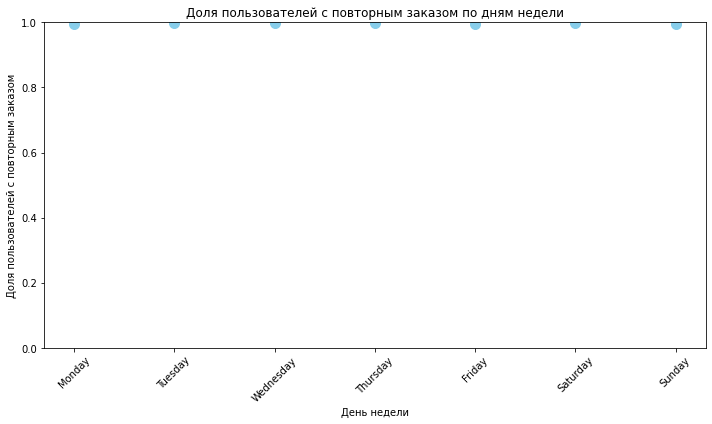

In [62]:
# Визуализация (не очень удачная - столбчатая диаграмма и бокс-плот тоже некрасивые...)

plt.figure(figsize=(10, 6))
plt.scatter(return_rate_by_weekday.index, return_rate_by_weekday['return_rate'], color='skyblue', s=100)
plt.title('Доля пользователей с повторным заказом по дням недели')
plt.xlabel('День недели')
plt.ylabel('Доля пользователей с повторным заказом')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Подвывод для задачи 4.3.1:

На основе анализа данных о днях недели, в которые пользователи совершили первый заказ, можно сделать следующие выводы:

1. **Общее количество пользователей и доля возвратных пользователей**:
   - Для всех дней недели доля пользователей, совершивших повторные заказы, остается очень высокой, варьируясь от **99.58%** до **99.89%**.
   - Наибольшая доля возвратных пользователей наблюдается в **субботу** (99.89%), а наименьшая — в **пятницу** (99.61%).

2. **Влияние дня недели на вероятность возврата**:
   - Все дни недели демонстрируют схожие результаты по доле пользователей с повторными покупками, при этом различия между днями минимальны.
   - **День недели не имеет значительного влияния** на вероятность возврата клиента, так как доля возвратных пользователей почти одинаковая для всех дней, с незначительными колебаниями.

3. **Вывод**:
   - Данные показывают, что день недели, в который была совершена первая покупка, не оказывает значимого влияния на вероятность возврата клиента. Высокая доля возвратных пользователей наблюдается во всех днях недели, что свидетельствует о стабильном поведении пользователей вне зависимости от дня их первого заказа.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [63]:
two_four_order_users = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
five_plus_order_users = user_profile[user_profile['total_orders'] >= 5]

avg_days_two_four = two_four_order_users['avg_days_between_orders'].mean()
avg_days_five_plus = five_plus_order_users['avg_days_between_orders'].mean()

print(f'Средний интервал между заказами для пользователей с 2-4 заказами: {avg_days_two_four:.2f} дней')
print(f'Средний интервал между заказами для пользователей с 5 и более заказами: {avg_days_five_plus:.2f} дней')

Средний интервал между заказами для пользователей с 2-4 заказами: 21.52 дней
Средний интервал между заказами для пользователей с 5 и более заказами: 11.19 дней


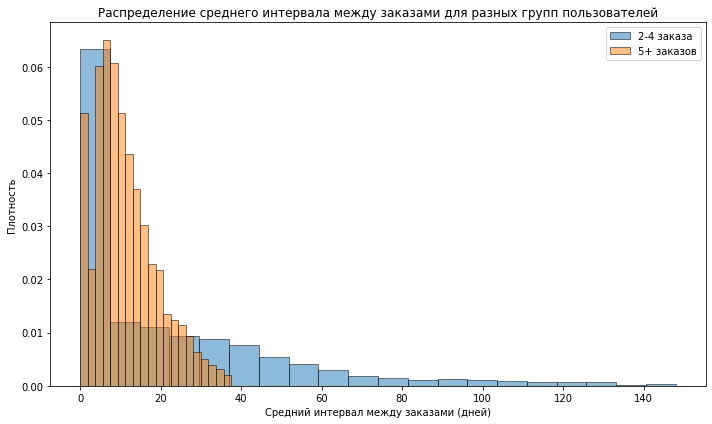

In [64]:
# Визуализация (ура, тут нет долей 0.99+++)

plt.figure(figsize=(10, 6))

plt.hist(two_four_order_users['avg_days_between_orders'], bins=20, alpha=0.5, label='2-4 заказа', density=True, edgecolor='black')

# Гистограмма для пользователей с 5 и более заказами
plt.hist(five_plus_order_users['avg_days_between_orders'], bins=20, alpha=0.5, label='5+ заказов', density=True, edgecolor='black')

plt.title('Распределение среднего интервала между заказами для разных групп пользователей')
plt.xlabel('Средний интервал между заказами (дней)')
plt.ylabel('Плотность')
plt.legend()
plt.tight_layout()
plt.show()

#### Подвывод для задачи 4.3.2:

На основе анализа среднего интервала между заказами для двух групп пользователей можно сделать следующие выводы:

1. **Средний интервал между заказами**:
   - Для пользователей с 2-4 заказами средний интервал составляет **21.52 дня**, что свидетельствует о более длительных промежутках между заказами.
   - Для пользователей с 5 и более заказами интервал составляет **11.19 дня**, что говорит о более высокой вовлеченности и более коротких промежутках между заказами.

2. **Распределение**:
   - Пользователи с 5 и более заказами склонны к более частым покупкам, что видно по их более компактному распределению интервалов (большая часть пользователей делает заказы с интервалом менее 20 дней).
   - Пользователи с 2-4 заказами имеют более разнообразное распределение интервалов, что может свидетельствовать о меньшей вовлеченности, чем у пользователей с более высоким числом заказов.

#### Вывод:
**Интервал между заказами** явно влияет на удержание клиентов: чем меньше интервал, тем выше вовлеченность и вероятность повторных покупок. Пользователи с 5 и более заказами показывают более короткие интервалы и, вероятно, более высокую лояльность к сервису.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [65]:
phik_df = user_profile.drop(columns=['user_id', 'is_five', 'is_two']).copy() # user_id нам не нужен

categorical_cols = ['first_device', 'first_region', 'first_service_name', 'first_event_type', 'first_order_weekday']
for col in categorical_cols:
    phik_df[col] = phik_df[col].astype('category')
    
corr_matrix = phik_matrix(phik_df, interval_cols=['avg_revenue', 'avg_tickets_count', 'avg_days_between_orders', 'total_orders'])

total_orders_corr = corr_matrix.loc['total_orders'].drop('total_orders').sort_values(ascending=False)

display(total_orders_corr)

avg_days_between_orders    0.494798
first_order_date           0.371552
last_order_date            0.358669
avg_tickets_count          0.333760
avg_revenue                0.229501
first_region               0.055161
first_device               0.050314
first_event_type           0.027975
first_service_name         0.027383
first_order_weekday        0.019364
Name: total_orders, dtype: float64

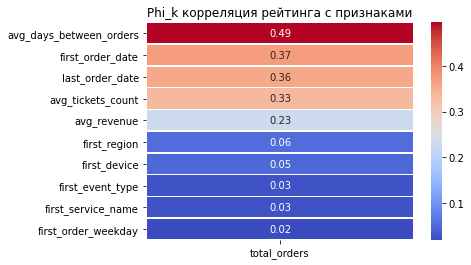

In [66]:
# Тепловая карта

plt.figure(figsize=(6,4))

sns.heatmap(total_orders_corr.to_frame(name='total_orders'),
            annot=True, fmt='.2f', linewidth=0.5, cmap='coolwarm')

plt.title('Phi_k корреляция рейтинга с признаками')
plt.show()

#### Подвывод для задачи 4.4.1:

На основе корреляционного анализа между признаками профиля пользователя и количеством заказов (**`total_orders`**) можно сделать следующие выводы:

1. **Ключевые выводы из анализа корреляции**:
   - **Наибольшая корреляция** наблюдается с **`avg_days_between_orders`**, с коэффициентом **0.49**, что свидетельствует о средней связи между количеством заказов и промежутками времени между ними. Это подтверждает, что более частые заказы имеют тенденцию быть связаны с меньшими интервалами между заказами.
   - Значительная корреляция также наблюдается с датой первого заказа (**`first_order_date`**, 0.37) и датой последнего заказа (**`last_order_date`**, 0.36). Это указывает на то, что более ранние заказы и недавние активности пользователей положительно связаны с более высокими значениями **`total_orders`**.
   - Влияние **`avg_tickets_count`** (0.33) и **`avg_revenue`** (0.23) также подтверждает, что количество заказов связано с количеством покупаемых билетов и общей выручкой.
   
2. **Менее значимые признаки**:
   - Признаки **`first_region`**, **`first_device`**, **`first_event_type`**, **`first_service_name`** и **`first_order_weekday`** имеют **низкие значения корреляции** с **`total_orders`**, что указывает на их слабую связь с количеством заказов.

3. **Причина невозможности расчёта корреляции при сегментации**:
   - При попытке разбить пользователей на сегменты по количеству заказов, выяснилось, что **пользователей с 1 заказом оказалось очень мало (около 0.01% от выборки)**. Это делает невозможным адекватный расчёт корреляции для этой группы, так как выборка становится недостаточной для проведения статистического анализа. Корреляция для группы с 1 заказом может не давать полезных результатов из-за нехватки данных.
   - Поэтому анализ проводился на общем наборе данных, и результат корреляции с **`total_orders`** был рассчитан для всей выборки без дополнительной сегментации.

#### Заключение:
- **`avg_days_between_orders`** и **`first_order_date`** являются наиболее сильными предсказателями количества заказов.
- Разбиение на сегменты по количеству заказов не смогло быть выполнено для группы с 1 заказом из-за недостаточности данных, что ограничило возможность точного анализа для этой подгруппы.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Итоговый вывод и рекомендации

### Информация о данных и их подготовка
Мы работали с данными пользователей платформы **Яндекс Афиша**, включая информацию о заказах, пользователях, типах устройств, мероприятиях и прочее. Данные были очищены и подготовлены следующим образом:
- Преобразованы столбцы с датами и временем в соответствующие форматы.
- Отфильтрованы выбросы в числовых данных (выручка, количество билетов).
- Пропуски в столбцах были обработаны, что позволило улучшить качество анализа.
- Проведен анализ распределения данных и их нормализация для дальнейшего использования в моделях.

### Основные результаты анализа
1. **Пользователи**:
   - В выборке 21,820 пользователей, из которых 61.76% совершили два и более заказа.
   - Средняя выручка с одного заказа составляет 519.49 рублей, с колебаниями по числу заказов.
   - Важно отметить, что пользователи с первым заказом на спортивные мероприятия возвращаются чаще (18.24%) по сравнению с пользователями, заказавшими билеты на концерты (15.93%).

2. **Типы мероприятий и устройства**:
   - Концерты являются наиболее популярным типом мероприятия (45.18% пользователей), а мобильные устройства преобладают среди пользователей (82.24%).
   - Сегменты с малым числом пользователей, такие как выставки или ёлки, показывают 100% возврат пользователей, что связано с небольшим количеством заказов.

3. **Влияние региона и билетного оператора**:
   - Различия между регионами незначительны, хотя малые регионы показывают 100% возврат пользователей.
   - В крупных операторах, таких как "Билеты без проблем", наблюдается высокая доля возвратных пользователей.

4. **Корреляционный анализ**:
   - Наибольшую корреляцию с количеством заказов имеют среднее время между заказами (avg_days_between_orders) и дата первого заказа. Это подтверждает, что более частые заказы связаны с меньшими интервалами между ними.
   - Количество билетов в заказе и общая выручка также оказались связанными с числом заказов, что подтверждает важность этих факторов.

### Рекомендации
1. **Фокус на активных пользователях**:
   - Рекомендуется сосредоточить усилия на удержании пользователей, совершивших хотя бы два заказа. Это сегмент с высокой лояльностью, составивший более 60% выборки.
   
2. **Повышение лояльности через типы мероприятий**:
   - Обратить внимание на популярные типы мероприятий, такие как концерты, которые привлекают большинство пользователей. Меньшие сегменты, такие как ёлки и выставки, также могут быть интересны для дальнейших маркетинговых усилий.
   
3. **Маркетинговые усилия для мобильных пользователей**:
   - С учетом высокой доли пользователей, использующих мобильные устройства, стоит усилить мобильные маркетинговые кампании и улучшить мобильное приложение.

4. **Оптимизация предложения по регионам**:
   - В регионах с малым количеством пользователей можно предложить более таргетированные акции или мероприятия для увеличения вовлеченности.

5. **Рекомендации по выручке**:
   - Пользователи с одним заказом имеют гораздо большую выручку на заказ по сравнению с возвратными пользователями. Стоит предложить персонализированные скидки или бонусы, чтобы увеличить объем покупок у этих пользователей.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.


**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/2Myaka2/Project_1.git